# In this notebook we use a LSTM neural network to determine the feelings caused by covid vaccines from tweets

In [1]:
!pip install tweet-preprocessor 2>/dev/null 1>/dev/null

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from matplotlib import dates
import matplotlib.dates as mdates
from tqdm import tqdm
import preprocessor as p
import emoji

In [3]:
data = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [4]:
data = data[data["text"].notna()]

In [5]:
print(data[ data['sentiment'] == 'positive'].size)
print(data[ data['sentiment'] == 'neutral'].size)
print(data[ data['sentiment'] == 'negative'].size)

17164
22234
15562


# Preprocess text

### Contractions 

In [6]:
contractions = pd.read_csv("/kaggle/input/contractions/contractions.csv")
cont_dic = dict(zip(contractions.Contraction, contractions.Meaning))

def cont_to_meaning(val): 
  
    for x in val.split(): 
        if x in cont_dic.keys(): 
            val = val.replace(x, cont_dic[x]) 
    return val

data['text'] = data['text'].apply(lambda x : cont_to_meaning(x))

### Remove Mentions and URL

In [7]:
p.set_options(p.OPT.MENTION, p.OPT.URL)
data['text'] = data['text'].apply(lambda x : p.clean(x))

### Convert emoji, keep only alphanumeric characters

In [8]:
data['text'] = data['text'].apply(lambda x: emoji.demojize(str(x).lower()))
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [9]:
def clean_text(val):
    val = cont_to_meaning(val)
    val = p.clean(val)
    val = emoji.demojize(str(val).lower())
    val = re.sub('[^a-zA-z0-9\s]','',val)
    
    return val

In [10]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

# Train / Valid split

In [11]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(21984, 33) (21984, 3)
(5496, 33) (5496, 3)


0: negative, 1 : neutral, 2 : positive

In [12]:
pd.get_dummies(data['sentiment'])

negative  neutral  positive
0             0        1         0
1             1        0         0
2             1        0         0
3             1        0         0
4             1        0         0
...         ...      ...       ...
27476         1        0         0
27477         1        0         0
27478         0        0         1
27479         0        0         1
27480         0        1         0

[27480 rows x 3 columns]

# LSTM Network

 embed_dim / lstm_out / batch_size / droupout_x variables are hyperparameters

In [13]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint = ModelCheckpoint("tweet.lstm.h5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=True)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 33, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
batch_size = 32
model.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs = 10, batch_size=batch_size, verbose = 1, callbacks=[checkpoint])

Epoch 1/10
687/687 [==============================] - 84s 120ms/step - loss: 0.9521 - accuracy: 0.5302 - val_loss: 0.7220 - val_accuracy: 0.6951

Epoch 00001: val_accuracy improved from -inf to 0.69505, saving model to tweet.lstm.h5
Epoch 2/10
687/687 [==============================] - 81s 119ms/step - loss: 0.6779 - accuracy: 0.7224 - val_loss: 0.6843 - val_accuracy: 0.7102

Epoch 00002: val_accuracy improved from 0.69505 to 0.71015, saving model to tweet.lstm.h5
Epoch 3/10
687/687 [==============================] - 81s 118ms/step - loss: 0.6234 - accuracy: 0.7474 - val_loss: 0.6716 - val_accuracy: 0.7129

Epoch 00003: val_accuracy improved from 0.71015 to 0.71288, saving model to tweet.lstm.h5
Epoch 4/10
687/687 [==============================] - 81s 118ms/step - loss: 0.5991 - accuracy: 0.7532 - val_loss: 0.6661 - val_accuracy: 0.7209

Epoch 00004: val_accuracy improved from 0.71288 to 0.72089, saving model to tweet.lstm.h5
Epoch 5/10
687/687 [==============================] - 81s 1

In [15]:
# load best weights
model.load_weights('./tweet.lstm.h5')

In [16]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

172/172 - 4s - loss: 0.7230 - accuracy: 0.7247
score: 0.72
acc: 0.72


In [17]:
pred = model.predict(X_test)

### Plot confusion matrix to have better idea of how perform our model

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


<AxesSubplot:>

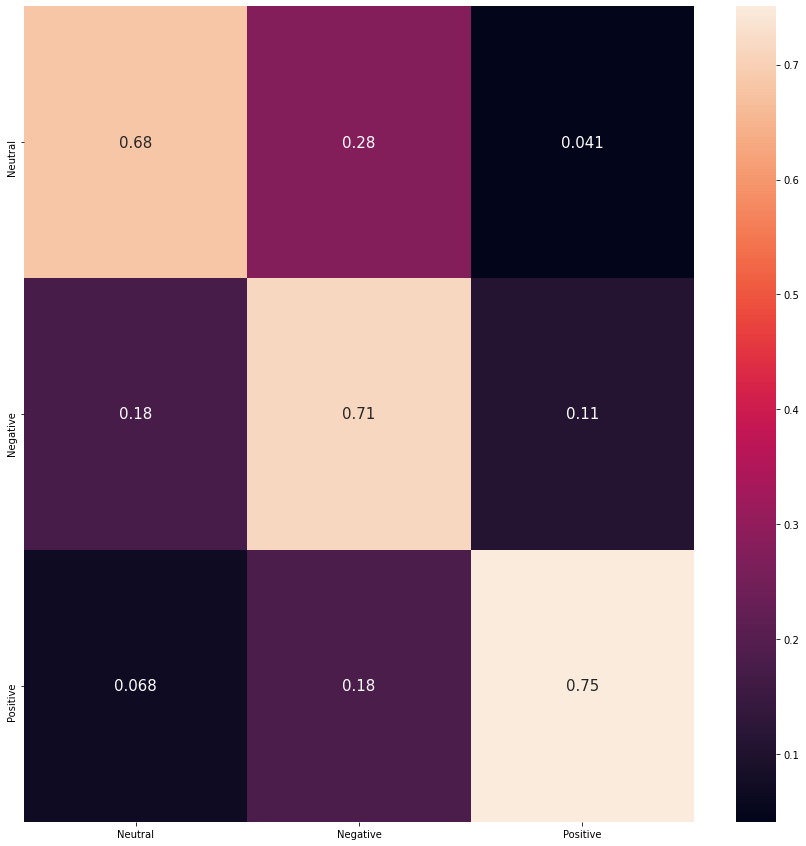

In [18]:
matrix = confusion_matrix(Y_test.argmax(axis=1), np.around(pred, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

### Performances may be optimized with more hyperparameter tuning 
### But it's not so bad to take a look at the tweets about covid vaccination.

In [19]:
sentiment = ['Negative','Neutral','Positive']

# Using tweet dataset containing vaccines name related to coronavirus

In [20]:
tweetdata = pd.read_csv('../input/all-covid19-vaccines-tweets/vaccination_all_tweets.csv')

In [21]:
#preprocess
tweetdata['text'] = tweetdata['text'].apply(clean_text)
tweetdata = tweetdata[tweetdata["text"].notna()]
tweetdata = tweetdata[tweetdata['text'] != '']

In [22]:
#make predictions
tweetdata["sentiment"] = np.nan

for idx,row in tqdm(tweetdata.iterrows()):
    sequence = tokenizer.texts_to_sequences(row['text'])
    test = pad_sequences(sequence)
    tweetdata["sentiment"][idx] = sentiment[np.argmax(model.predict(test)[0])]

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
60088it [49:25, 20.26it/s]


In [23]:
tweetdata = tweetdata.dropna()

In [24]:
tweetdata['date'] = pd.to_datetime(tweetdata["date"]).dt.strftime('%m-%d-%Y')

In [36]:
idx = tweetdata[pd.to_datetime(tweetdata["date"]).dt.month > 3].index
tweetdata = tweetdata.drop(idx)

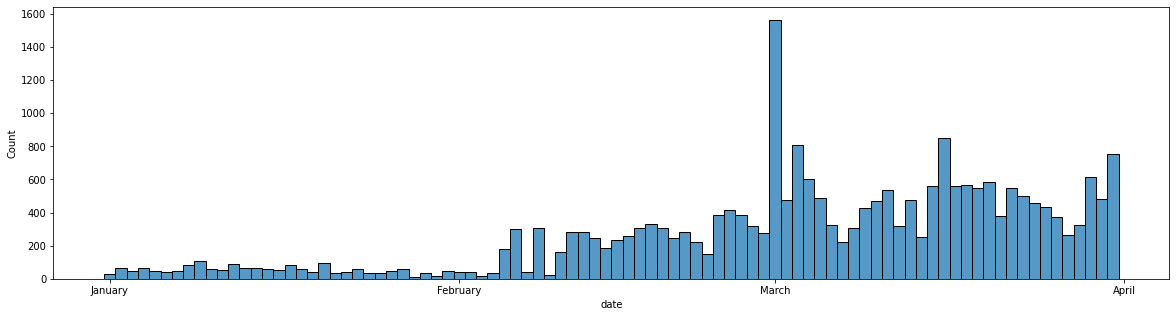

In [37]:
fmt_month = mdates.MonthLocator()
fig, ax = plt.subplots(figsize=(20,5))
sns.histplot(data=tweetdata, x="date")
#fmt_month = mdates.MonthLocator()
ax.xaxis.set_major_locator(fmt_month)
ax.xaxis.set_major_formatter(dates.DateFormatter("%B"))

### We have more data for february and march

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

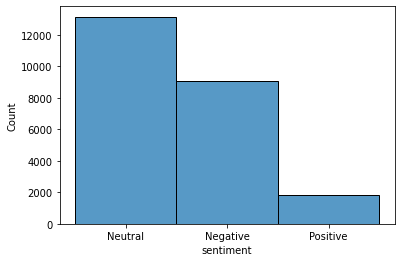

In [38]:
# Plot sentiment value counts
sns.histplot(data=tweetdata, x="sentiment")

### We have majority of neutral sentiment prediction 
### And we have many more predictions of negative sentiment than positive ones. 

How sentiments have changed over time

In [39]:
data_viz = tweetdata[['date','sentiment']].groupby(['date','sentiment'])['sentiment'].count().reset_index(name="count")

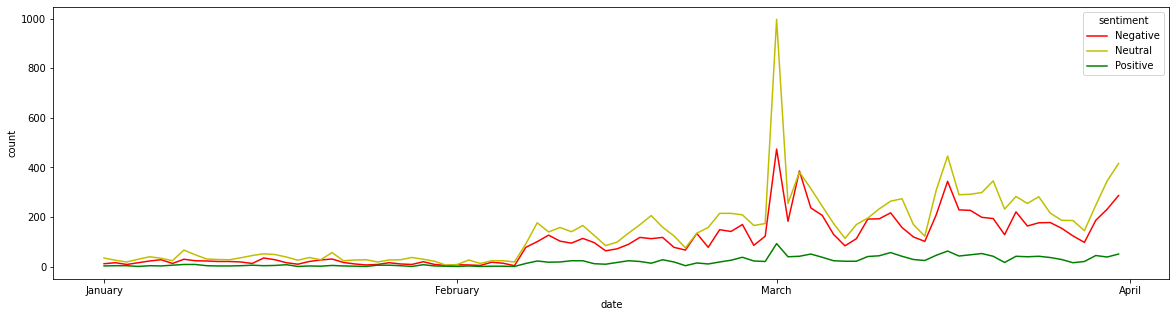

In [40]:
fig, ax = plt.subplots(figsize=(20,5))
chart = sns.lineplot(data=data_viz, x='date', y='count', hue='sentiment', palette={'Negative':'r', 'Neutral':'y', 'Positive':'g'})
fmt_month = mdates.MonthLocator()
ax.xaxis.set_major_locator(fmt_month)
ax.xaxis.set_major_formatter(dates.DateFormatter("%B"))

### Now let's compare the four vaccines below

In [46]:
all_vax = ['moderna', 'pfizer', 'astrazeneca', 'sputnik']

<BarContainer object of 4 artists>

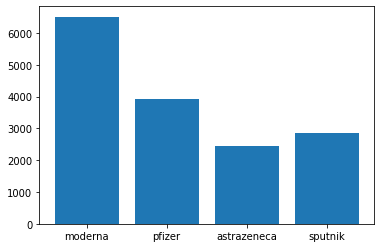

In [48]:
d = {}
for vax in all_vax :
    d[vax] =  len(tweetdata[tweetdata["text"].str.contains(vax)])

plt.bar(d.keys(), d.values())

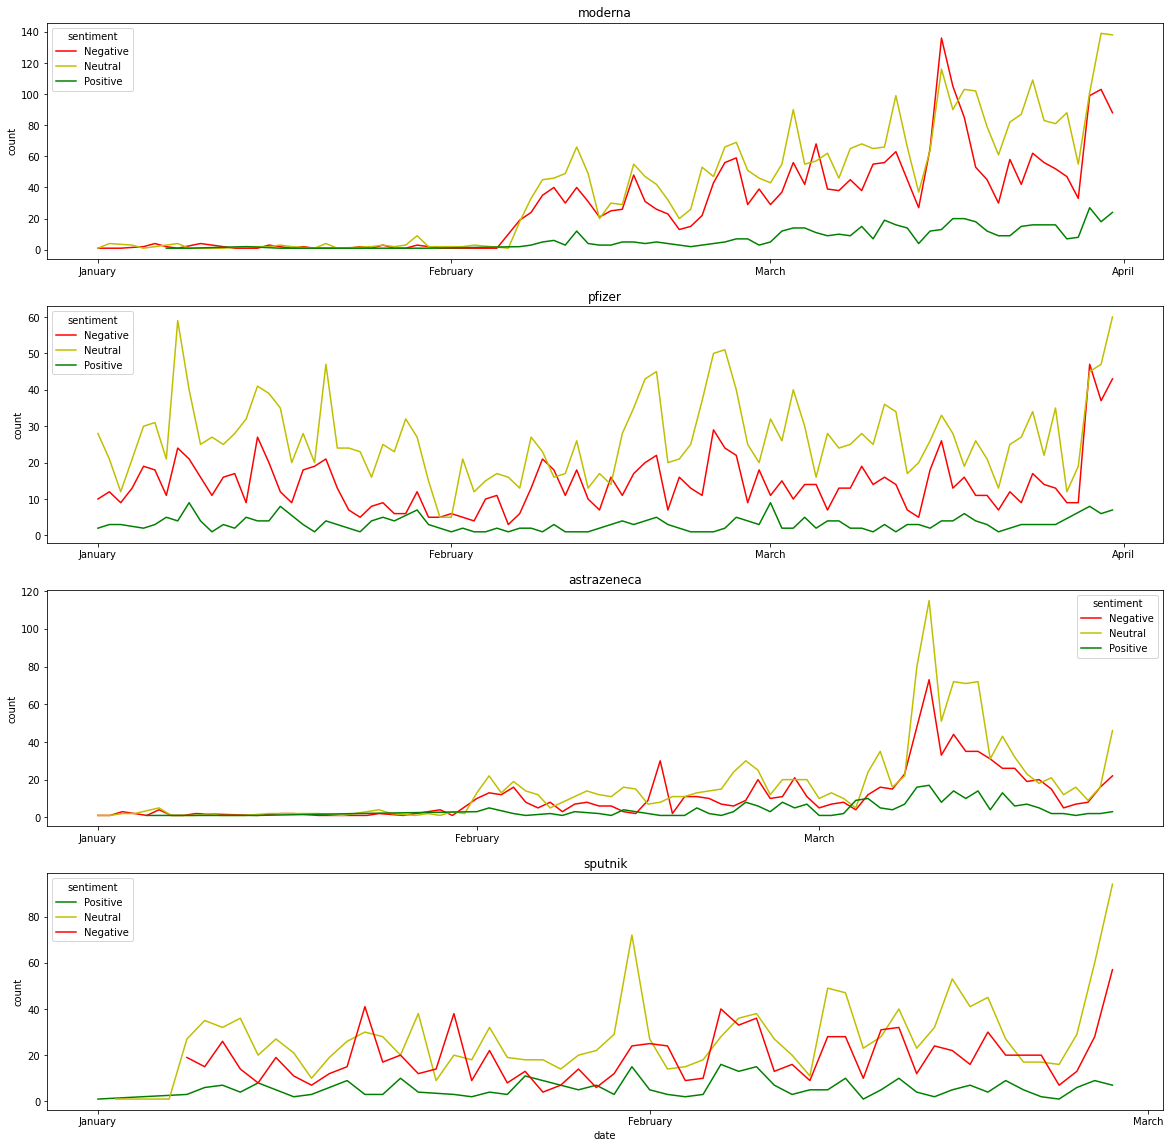

In [50]:
vax_recap = {}
fig, ax = plt.subplots(4,1,figsize=(20,20))
for i, vax in enumerate(all_vax) :
    data = tweetdata[tweetdata["text"].str.contains(vax)]
    vax_recap[vax] = data
    data_viz = data[['date','sentiment']].groupby(['date','sentiment'])['sentiment'].count().reset_index(name="count")
    chart = sns.lineplot(data=data_viz, x='date', y='count', hue='sentiment', ax=ax[i], palette={'Negative':'r', 'Neutral':'y', 'Positive':'g'})
    ax[i].set_title(vax)
    
    if i != len(all_vax)-1 : ax[i].set_xlabel("")
    fmt_month = mdates.MonthLocator()
    ax[i].xaxis.set_major_locator(fmt_month)
    ax[i].xaxis.set_major_formatter(dates.DateFormatter("%B"))

# Z score

To conclude, we will calculate the Z score to see which vaxin is best received. 

Text(0.5, 0, 'Z score')

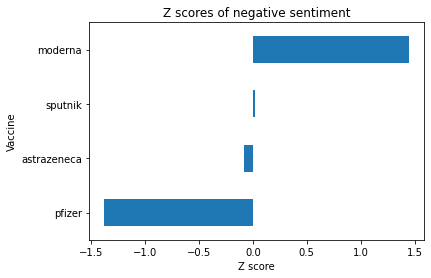

In [51]:
### Get z scores of sentiment for each vaccine
sentiment_zscores = pd.DataFrame()
for k, v in vax_recap.items():
    senti = v['sentiment'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['Negative', 'Neutral', 'Positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('Negative_zscore')['Negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score')

### Moderna seems to attract much more negative sentiment than the other vaccines, while Pfizer, on the other hand, seems to be better regarded